In [65]:
%pylab inline

import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import IPython.display
import cmocean as cm
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import pylab
from matplotlib import ticker, cm
# for georefferenced data
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm # for colormap

from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn import preprocessing
from dask.diagnostics import ProgressBar

from scipy import stats
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/g/data/w35/ccc561/tmp'})
#import dask.multiprocessing
#dask.config.set(scheduler='processes')
import sys, os
sys.path.append(os.path.join(os.getcwd(), '/g/data/w35/ccc561/tmp'))  # so we can import ../exptdata

import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [66]:
#client =
#cc.start_cluster()
#client
client = Client()
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:45444 Dashboard: http://127.0.0.1:37919/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [67]:
aviso_clim_tstart = pd.to_datetime('1992', format='%Y')
aviso_clim_tend = aviso_clim_tstart + pd.DateOffset(years=27)
firstyear = pd.to_datetime(aviso_clim_tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(aviso_clim_tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('aviso_clim_tstart = ', aviso_clim_tstart)
print('aviso_clim_tend = ', aviso_clim_tend)

1992-2018
aviso_clim_tstart =  1992-01-01 00:00:00
aviso_clim_tend =  2019-01-01 00:00:00


In [68]:
cc.build_index()

Finding runs in /g/data3/hh5/tmp/cosima/... found 7193 run directories
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Querying database for directories... run directories already indexed: 12133
Finding files in 16 run directories... 


Files found but not yet indexed: 0
No new .nc files found in /g/data3/hh5/tmp/cosima/
Finding runs in /g/data1/v45/APE-MOM... <class 'subprocess.CalledProcessError'> exception occurred while finding output directories in /g/data1/v45/APE-MOM
found 0 run directories
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
No new runs found in /g/data1/v45/APE-MOM
Indexing complete.


True

In [69]:
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
SSTm = cc.get_nc_variable(expt,'ocean_month.nc','surface_temp',
                                 n=n_files,time_units=time_units, offset=offset,use_cache=True)\
                                 .sel(time=slice(aviso_clim_tstart,aviso_clim_tend)) 

sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset,use_cache=True)\
                                 .sel(time=slice(aviso_clim_tstart,aviso_clim_tend))
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset,use_cache=True)\
                                 .sel(time=slice(aviso_clim_tstart,aviso_clim_tend))
var_sl= sea_levelsq - sea_level**(2.0)
std_sl=(sea_levelsq - sea_level**(2.0))**(0.5)

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_surface_temp_-12_days-since-1718-01-01_-87658_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_sea_level_-12_days-since-1718-01-01_-87658_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_sea_levelsq_-12_days-since-1718-01-01_-87658_False.pkl


In [70]:
var_sl

<xarray.DataArray (time: 312, yt_ocean: 300, xt_ocean: 360)>
dask.array<shape=(312, 300, 360), dtype=float32, chunksize=(1, 300, 360)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * time      (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16T12:00:00

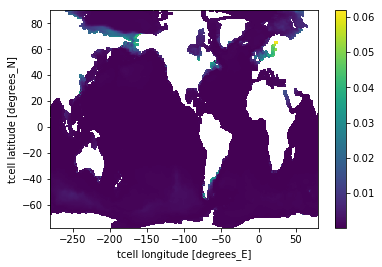

In [71]:
var_sl.mean('time').plot()

In [72]:
print(var_sl.nbytes /1024**3,'GB')

0.12552738189697266 GB


In [73]:
SST = SSTm.sel(xt_ocean=slice(-170,-120)).sel(yt_ocean=slice(-5,5))- 273.15

In [74]:
SST_avg=SST.mean('xt_ocean').mean('yt_ocean')

In [75]:
SSTa=(SST_avg.groupby('time.month')-SST_avg.groupby('time.month').mean('time'))

In [76]:
var_sl_reg = var_sl.sel(xt_ocean=slice(-260,-100)).sel(yt_ocean=slice(-60,10))
varm=(var_sl_reg.groupby('time.month')-var_sl_reg.groupby('time.month').mean('time'))

In [79]:
def least_sq_correlation(da, test):
    """
    Calculate the least squares correlation against multiple
    locations simultaneously
    
    Args:
        da (xarray.DataArray): Input data field
        test: 1D Timeseries to test all locations against
        
    Returns:
        xarray.DataArray with correlation coefficients (rvalue) at                                                                            
        each location
        
    Time should be the first axis of 'da', and this axis should be
    the same size as the 'test' timeseries
    
    Implementation is copied from scipy.stats.linregress, modified 
    to work on multiple series
    """
    assert test.ndim == 1
    assert da.shape[0] == test.shape[0]
    
    shape = da.shape
    
    # Block other dims together
    arr = da.data.reshape((shape[0], -1))
    
    # Get covariance
    cov = dask.array.cov(arr.T, test, bias=1)
    
    # Get variances and covariance with 'test'
    ssxm = dask.array.diagonal(cov)[0:-1]
    ssym = cov[-1,-1]
    ssxym = cov[-1,0:-1]
    
    # Compute 'r' value                                                      
    r_num = ssxym
    r_den = dask.array.sqrt(ssxm * ssym)
    r = r_num / r_den
    
    slope = r_num / ssxm
    # Return to original shape
    r = r.reshape(shape[1:])
    slope = slope.reshape(shape[1:])

    # Add xarray metadata from the input dataarray
    da_out = xr.DataArray(r, dims=da.dims[1:], coords={k:v for k,v in da.coords.items() if k in da.dims[1:]})
    d_slope = xr.DataArray(slope,dims=da.dims[1:], coords={k:v for k,v in da.coords.items() if k in da.dims[1:]})

    # Concatenate r and slope in same DataArray. Add a stats coordinate and concat along it.
    #da_out.name = 'rvalue'
    d_slope.coords['stats'] = 'slope'
    da_out.coords['stats'] = 'rvalue'
    da_out = xr.concat([da_out, d_slope], 'stats')
    return da_out

In [80]:
%time
print(varm.nbytes /1024**3,'GB')
print(SSTa.nbytes /1024**3,'GB')
var_out=least_sq_correlation(varm,SSTa)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.2 µs
0.023059844970703125 GB
1.1622905731201172e-06 GB


In [81]:
# Why this?
#var_out.compute()
var_out

<xarray.DataArray (stats: 2, yt_ocean: 124, xt_ocean: 160)>
dask.array<shape=(2, 124, 160), dtype=float64, chunksize=(1, 124, 160)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -59.93 -59.22 -58.5 -57.76 ... 9.167 9.5 9.834
  * xt_ocean  (xt_ocean) float64 -259.5 -258.5 -257.5 ... -102.5 -101.5 -100.5
  * stats     (stats) <U6 'rvalue' 'slope'

In [82]:
varmt = var_out.sel(stats='slope')
var_r = var_out.sel(stats='rvalue')

In [83]:
varmt

<xarray.DataArray (yt_ocean: 124, xt_ocean: 160)>
dask.array<shape=(124, 160), dtype=float64, chunksize=(124, 160)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -59.93 -59.22 -58.5 -57.76 ... 9.167 9.5 9.834
  * xt_ocean  (xt_ocean) float64 -259.5 -258.5 -257.5 ... -102.5 -101.5 -100.5
    stats     <U6 'slope'

MemoryError: 

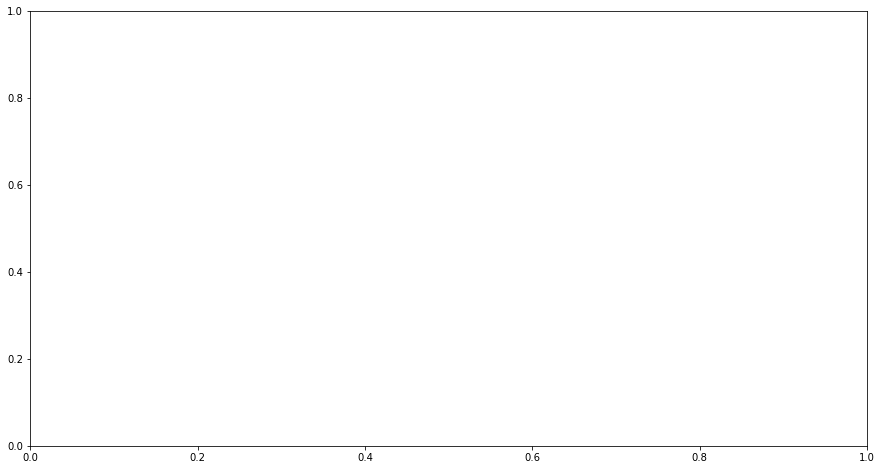

distributed.nanny - WARNING - Worker process 32294 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 32296 was killed by unknown signal
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 32290 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


In [84]:
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(varmt.xt_ocean,varmt.yt_ocean)
h=plt.contourf(X,Y,varmt.data,levels=50)
cb = plt.colorbar(h,orientation='vertical')